In [143]:
#import os
#os.environ['PYTHONPATH'] += '/home/lee.mcculler/GWPhotonCounting/src/:'
#os.environ['PYTHONPATH']

# needs https://git.ligo.org/jacob.golomb/bilby/-/tree/long_wavelength
# which needs to be on branch long_wavelength
# also https://git.ligo.org/jacob.golomb/bilby-cython/-/tree/long_wavelength?ref_type=heads
# and install needed OPENBLAS_NUM_THREADS=1 pip install -e . to fix a numpy issue

In [144]:
import matplotlib.pyplot as plt
import numpy as np

import GWPhotonCounting

from jax.scipy.special import logsumexp

from scipy.interpolate import interp1d
from jax.lax import cumlogsumexp

In [145]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from copy import copy
params = {
   'axes.labelsize': 10,
   'font.size': 10,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'axes.titlesize':10,
   'text.usetex': True,
   'font.family':'serif',
   'font.serif':'Computer Modern'
   }
matplotlib.rcParams.update(params)
matplotlib.rcParams["font.serif"] = "Computer Modern Roman"
matplotlib.rcParams["font.family"] = "Serif"
matplotlib.rcParams['text.latex.preamble'] = r'\renewcommand{\mathdefault}[1][]{}'

from matplotlib.markers import MarkerStyle
import matplotlib as mpl

In [146]:
import glob, json
from tqdm import tqdm 

from scipy.signal import savgol_filter
sg_poly = 2
sg_nodes = 10


Nevents = 100
Noffs = 0

loglikelihoods = []
loglikelihoods_no_background = []
loglikelihoods_0d1 = []
loglikelihoods_strain = []
loglikelihoods_strain_15db = []
loglikelihoods_strain_20db = []

signal_photons = []
noise_photons = []
noise_photons_0d01 = []
noise_photons_0d1 = []
snrs = []
snrs_fit_pc = []
snrs_silica = []
indices = []
log10A_fit_pc = []
log10A_fit_strain = []
log10A_fit_strain_15db = []

#260216d is a good set but has outliers that screw things up
#260216e has the log likelihood doubled which is probably wrong
file_list = glob.glob("results_260219nnT0/result_CE_*.json") #250623 is the newer result
file_list.sort(key=lambda file: int(file.split("_")[-1].split(".")[0]))
#file_list = glob.glob("results_250623/result_CE_*.json") #250623 is the newer result
#file_list = glob.glob("results_250622/result_CE_*.json") 


R1d6s_interp = np.linspace(10,14,1000)
R1d6s = np.linspace(10,14,100)

for i in tqdm(range(len(file_list[Noffs:Noffs+Nevents]))):
    file = file_list[i+Noffs] #f'results_250410/result_CE1CE2silica_{10900 + i}.json'
    #MASK TODO REMOVE
    #mask = np.array([[ 624],[ 899],[ 936],[ 984],[1285],[1598],[1872],[2080],[2206],[2637]]) # for results_260216f
    mask = []
    if i + Noffs in mask:
        continue


    indices.append(int(file.split("_")[-1].split(".")[0]))
    with open(file, "r") as f:
        #print(file)
        try:
            result = json.load(f)
        except Exception as E:
            print(f"Bad file: {file}", E)
            continue

    logls = interp1d(R1d6s, savgol_filter(result["logls"], sg_nodes, sg_poly), kind='cubic')(R1d6s_interp)
    logls_0d1 = interp1d(R1d6s, savgol_filter(result["logls_0d1"], sg_nodes, sg_poly), kind='cubic')(R1d6s_interp)
    logls_no_background = interp1d(R1d6s, savgol_filter(result["logls_no_background"], sg_nodes, sg_poly), kind='cubic')(R1d6s_interp)

    logls_strain = interp1d(R1d6s, savgol_filter(result["logls_strain"], sg_nodes, sg_poly), kind='cubic')(R1d6s_interp)
    logls_strain_15db = interp1d(R1d6s, savgol_filter(result["logls_strain_15db"], sg_nodes, sg_poly), kind='cubic')(R1d6s_interp)
    logls_strain_20db = interp1d(R1d6s, savgol_filter(result["logls_strain_20db"], sg_nodes, sg_poly), kind='cubic')(R1d6s_interp)
    

    # if np.max(logls) - np.min(logls) < 15:
    #     if np.max(logls_0d1) - np.min(logls_0d1) < 15:
    #         if np.max(logls_strain) - np.min(logls_strain) < 5:
    #             if np.max(logls_strain_15db) - np.min(logls_strain_15db) < 5:

    #if result["log10A_fit_pc"] < -21: #and result["log10A_fit_strain"] < -21 and result["log10A_fit_strain_15db"] < -21:
    if result['snr_sqz'] < 100:
        loglikelihoods.append(logls)
        loglikelihoods_0d1.append(logls_0d1)
        loglikelihoods_no_background.append(logls_no_background)

        loglikelihoods_strain.append(logls_strain)
        loglikelihoods_strain_15db.append(logls_strain_15db)
        loglikelihoods_strain_20db.append(logls_strain_20db)

        
        signal_photons.append(result["n_signal_photons"])
        noise_photons.append(result["n_noise_photons"])
        #noise_photons_0d01.append(result["n_noise_photons_0d01"])
        noise_photons_0d1.append(result["n_noise_photons_0d1"])
        snrs.append(result["snr"])
        #print(result["snr"])
        snrs_fit_pc.append(result["snr_fit_pc"])
        snrs_silica.append(result["snr_sqz"])

        #log10A_fit_pc.append(result["log10A_fit"])
        log10A_fit_pc.append(result["log10A_fit_pc"])
        #log10A_fit_strain.append(result["log10A_fit_strain"])
        #log10A_fit_strain_15db.append(result["log10A_fit_strain_15db"])

loglikelihoods = np.array(loglikelihoods)
loglikelihoods_0d1 = np.array(loglikelihoods_0d1)
loglikelihoods_no_background = np.array(loglikelihoods_no_background)
loglikelihoods_strain = np.array(loglikelihoods_strain)
loglikelihoods_strain_15db = np.array(loglikelihoods_strain_15db)
loglikelihoods_strain_20db = np.array(loglikelihoods_strain_20db)
signal_photons = np.array(signal_photons)
noise_photons = np.array(noise_photons)
noise_photons_0d01 = np.array(noise_photons_0d01)
noise_photons_0d1 = np.array(noise_photons_0d1)
snrs = np.array(snrs)
snrs_silica = np.array(snrs_silica)
snrs_fit_pc = np.array(snrs_fit_pc)

log10A_fit_pc = np.array(log10A_fit_pc)
log10A_fit_strain = np.array(log10A_fit_strain)
log10A_fit_strain_15db = np.array(log10A_fit_strain_15db)


100%|██████████| 10/10 [00:00<00:00, 188.13it/s]


In [147]:
Nevents = len(loglikelihoods)
print(Nevents)

10


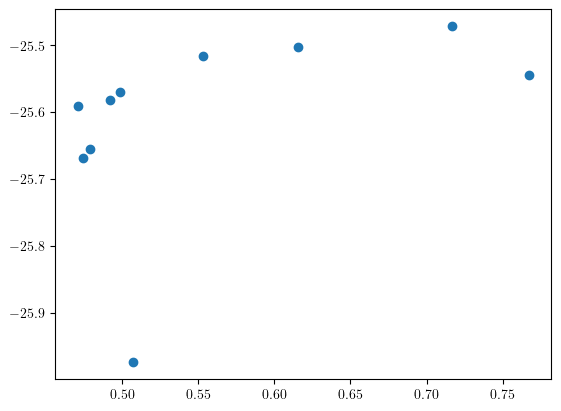

In [148]:
mask = signal_photons > 0
plt.scatter(snrs[mask], log10A_fit_pc[mask], color='red', zorder=100)

plt.scatter(snrs, log10A_fit_pc)

#plt.ylim(-10,0)

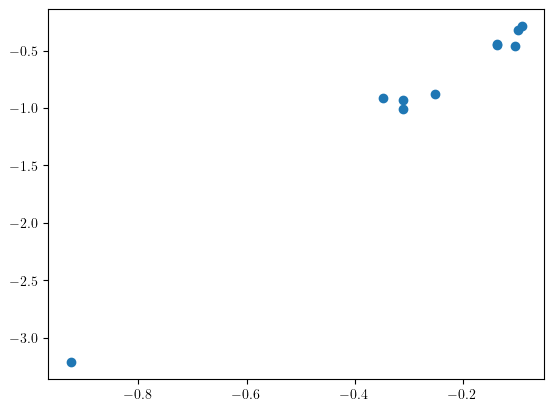

In [149]:
plt.scatter(np.min(loglikelihoods_strain.T-np.max(loglikelihoods_strain,axis=1),axis=0), np.min(loglikelihoods_strain_15db.T-np.max(loglikelihoods_strain_15db,axis=1),axis=0))

array([], shape=(0, 1), dtype=int64)

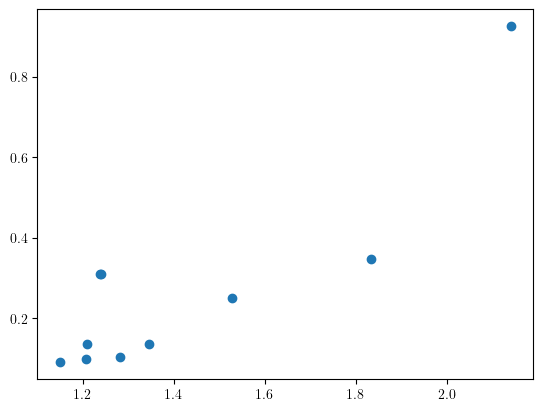

In [150]:
plt.scatter(snrs_silica, np.max(loglikelihoods_strain, axis=1) - np.min(loglikelihoods_strain, axis=1))
mask = np.argwhere(np.max(loglikelihoods_strain, axis=1) - np.min(loglikelihoods_strain, axis=1) > 1)
mask

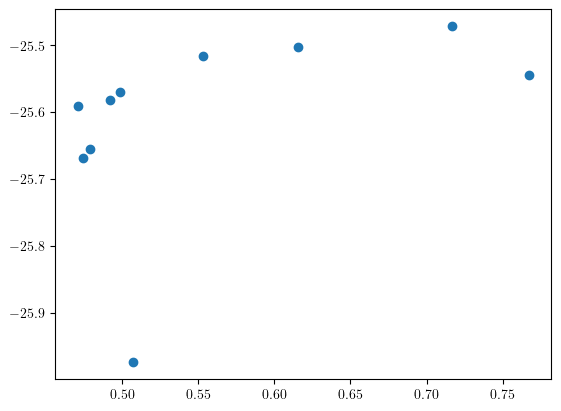

In [151]:
plt.scatter(snrs[mask], log10A_fit_pc[mask], color='red', zorder=100)

plt.scatter(snrs, log10A_fit_pc)

In [152]:
np.sum(signal_photons), np.sum(noise_photons), np.sum(noise_photons_0d01), np.sum(noise_photons_0d1)

(np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0))

In [153]:
print(np.quantile(snrs_silica, [0.95]))

[2.0018766]


In [154]:
print(np.sqrt(np.sum(snrs**2)), np.sqrt(np.sum(snrs_silica**2)))
print(np.mean(snrs), np.mean(snrs_silica))
print(np.median(snrs), np.median(snrs_silica))


1.7914581052142495 4.584711880663633
0.5572857249335927 1.4164563610994019
0.5027036205615956 1.2596871504451526


In [155]:


prob_pc = np.exp(np.sum(loglikelihoods, axis=0) - np.max(np.sum(loglikelihoods, axis=0)))
prob_pc /= np.sum(prob_pc)*(R1d6s[1]-R1d6s[0])

prob_pc_0d1 = np.exp(np.sum(loglikelihoods_0d1, axis=0) - np.max(np.sum(loglikelihoods_0d1, axis=0)))
prob_pc_0d1 /= np.sum(prob_pc_0d1)*(R1d6s[1]-R1d6s[0])

prob_pc_no_background = np.exp(np.sum(loglikelihoods_no_background, axis=0) - np.max(np.sum(loglikelihoods_no_background, axis=0)))
prob_pc_no_background /= np.sum(prob_pc_no_background)*(R1d6s[1]-R1d6s[0])

log_prob_strain = np.sum(loglikelihoods_strain, axis=0) - np.max(np.sum(loglikelihoods_strain, axis=0))
prob_strain = np.exp(log_prob_strain)
prob_strain /= np.sum(prob_strain)*(R1d6s[1]-R1d6s[0])

log_prob_strain_15db = np.sum(loglikelihoods_strain_15db, axis=0) - np.max(np.sum(loglikelihoods_strain_15db, axis=0))
prob_strain_15db = np.exp(log_prob_strain_15db)
prob_strain_15db /= np.sum(prob_strain_15db)*(R1d6s[1]-R1d6s[0])

log_prob_strain_20db = np.sum(loglikelihoods_strain_20db, axis=0) - np.max(np.sum(loglikelihoods_strain_20db, axis=0))
prob_strain_20db = np.exp(log_prob_strain_20db)
prob_strain_20db /= np.sum(prob_strain_20db)*(R1d6s[1]-R1d6s[0])


In [156]:
dataset = np.genfromtxt(f'/home/mcculler/photon_counting/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_MLE_250609.dat') #bns_pm_dataset_MLE_250509
mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, snr, snr_sqz = dataset.T

In [157]:
minimization = []

for R1d6 in R1d6s_interp:
    minimization.append(np.sum(-(f0_fit - GWPhotonCounting.hierarchical.frequency_model(mtots, R1d6)/(1+z))**2))

print(R1d6s_interp[np.argmax(minimization)], np.max(minimization))

11.073073073073074 -4825800.044006405


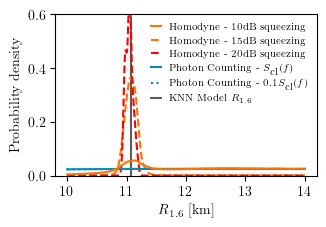

In [158]:
fig = plt.figure(figsize=(3.375,2.1))

from scipy.interpolate import interp1d

Rs = np.linspace(10,14,1000)

ymax = 0.65

plt.plot(Rs, interp1d(R1d6s_interp, prob_strain, kind='linear')(Rs), color='#ff7100ff', label='Homodyne - 10dB squeezing', zorder=100)
plt.plot(Rs, interp1d(R1d6s_interp, prob_strain_15db, kind='linear')(Rs), color='#ff7100ff', label='Homodyne - 15dB squeezing', ls='--')
plt.plot(Rs, interp1d(R1d6s_interp, prob_strain_20db, kind='linear')(Rs), color='#ff0000ff', label='Homodyne - 20dB squeezing', ls='--')
plt.plot(Rs, interp1d(R1d6s_interp, prob_pc, kind='linear')(Rs), color='#008eb8ff', label=r'Photon Counting - $S_\textrm{cl}(f)$', zorder=99)
plt.plot(Rs, interp1d(R1d6s_interp, prob_pc_0d1, kind='linear')(Rs), color='#008eb8ff', label=r'Photon Counting - $0.1S_\textrm{cl}(f)$', ls=':')
#plt.plot(Rs, interp1d(R1d6s_interp, prob_pc_no_background, kind='linear')(Rs), color='#000eb8ff', label=r'Photon Counting - $0S_\textrm{cl}(f)$', ls='--')
plt.plot([11.073, 11.073], [0, 0.9*ymax], color='#605B56', zorder=-10, label=r'KNN Model $R_{1.6}$')

#plt.xlim(9.5,13.5)
plt.ylabel(r'Probability density')
plt.xlabel(r'$R_{1.6}$ [km]')


legend = plt.legend(loc='upper right', frameon=True, handlelength=1, framealpha=1, edgecolor='white',fontsize=7)

#plt.ylim(0,0.63)
plt.ylim(0,0.6)
#plt.xlim(10,12)

plt.savefig("hierarchical.pdf", bbox_inches='tight')
#plt.savefig("hierarchical.png", bbox_inches='tight', dpi=300)

In [43]:
logl_pc = np.cumsum(loglikelihoods,axis=0)
logl_pc -= logsumexp(logl_pc, axis=1)[:,None]
logl_pc_cumul = cumlogsumexp(logl_pc, axis=1)
logl_pc_cumul -= np.max(logl_pc_cumul, axis=1)[:, None]

logl_pc_0d1 = np.cumsum(loglikelihoods_0d1,axis=0)
logl_pc_0d1 -= logsumexp(logl_pc_0d1, axis=1)[:,None]
logl_pc_0d1_cumul = cumlogsumexp(logl_pc_0d1, axis=1)
logl_pc_0d1_cumul -= np.max(logl_pc_0d1_cumul, axis=1)[:, None]

logl_pc_no_background = np.cumsum(loglikelihoods_no_background,axis=0)
logl_pc_no_background -= logsumexp(logl_pc_no_background, axis=1)[:,None]
logl_pc_no_background_cumul = cumlogsumexp(logl_pc_no_background, axis=1)
logl_pc_no_background_cumul -= np.max(logl_pc_no_background_cumul, axis=1)[:, None]

logl_strain = np.cumsum(loglikelihoods_strain,axis=0)
logl_strain -= logsumexp(logl_strain, axis=1)[:,None]
logl_strain_cumul = cumlogsumexp(logl_strain, axis=1)
logl_strain_cumul -= np.max(logl_strain_cumul, axis=1)[:,None]

logl_strain_15db = np.cumsum(loglikelihoods_strain_15db,axis=0)
logl_strain_15db -= logsumexp(logl_strain_15db, axis=1)[:,None]
logl_strain_15db_cumul = cumlogsumexp(logl_strain_15db, axis=1)
logl_strain_15db_cumul -= np.max(logl_strain_15db_cumul, axis=1)[:,None]

logl_strain_20db = np.cumsum(loglikelihoods_strain_20db,axis=0)
logl_strain_20db -= logsumexp(logl_strain_20db, axis=1)[:,None]
logl_strain_20db_cumul = cumlogsumexp(logl_strain_20db, axis=1)
logl_strain_20db_cumul -= np.max(logl_strain_20db_cumul, axis=1)[:,None]

pc_r1d6_widths = []
pc_r1d6_widths_0d1 = []
pc_r1d6_widths_strain = []
pc_r1d6_widths_strain_15db = []
pc_r1d6_widths_strain_20db = []
pc_r1d6_widths_no_background = []

interval = np.array([0.25,0.75])

for i in tqdm(range(Nevents)):
    bounds = interp1d(np.exp(logl_pc_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths.append(width_pc)

    bounds = interp1d(np.exp(logl_pc_0d1_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_0d1.append(width_pc)

    bounds = interp1d(np.exp(logl_pc_no_background_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_no_background.append(width_pc)

    bounds = interp1d(np.exp(logl_strain_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_strain.append(width_pc)

    bounds = interp1d(np.exp(logl_strain_15db_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_strain_15db.append(width_pc)

    bounds = interp1d(np.exp(logl_strain_20db_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_strain_20db.append(width_pc)


ERROR:2026-02-19 20:13:12,644:jax._src.xla_bridge:487: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/mcculler/miniconda3/envs/jaxGPU13/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 485, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/mcculler/miniconda3/envs/jaxGPU13/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/mcculler/miniconda3/envs/jaxGPU13/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load the CUDA libraries.
1

(0.0, 10000.0)

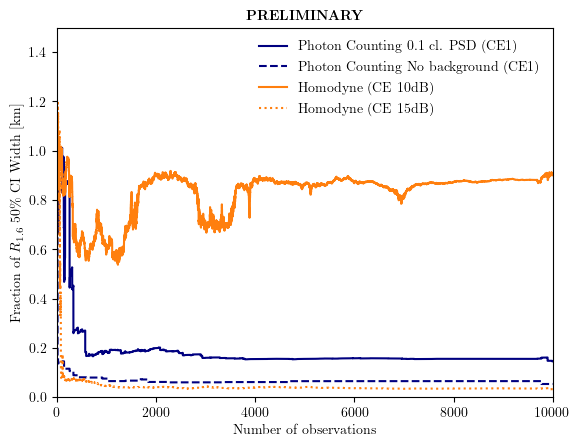

In [141]:
plt.step(np.linspace(0,Nevents,Nevents, dtype=int), np.array(pc_r1d6_widths)/(0.50 * 4), color="navy", label='Photon Counting 0.1 cl. PSD (CE1)')
plt.step(np.linspace(0,Nevents,Nevents, dtype=int), np.array(pc_r1d6_widths_no_background)/(0.50 * 4), color="navy", ls='--', label='Photon Counting No background (CE1)')
plt.step(np.linspace(0,Nevents,Nevents, dtype=int), np.array(pc_r1d6_widths_strain)/(0.50 * 4), color="C1", label='Homodyne (CE 10dB)')
plt.step(np.linspace(0,Nevents,Nevents, dtype=int), np.array(pc_r1d6_widths_strain_15db)/(0.50 * 4), color="C1", ls=':', label='Homodyne (CE 15dB)')

plt.ylabel(r'Fraction of $R_{1.6}$ 50\% CI Width [km]')
plt.xlabel(r'Number of observations')

#plt.plot(np.linspace(0,Nevents,Nevents, dtype=int), 2/np.sqrt(np.linspace(0,Nevents,Nevents, dtype=int)), color='k', ls='--', label=r'$\propto 1/\sqrt{N}$')
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.title(r'\textbf{PRELIMINARY}')

plt.ylim(0,1.5)
plt.xlim(0,Nevents)

In [142]:
### Ordering events by the snrs

sorted_indices = np.argsort(snrs)[::-1]
sorted_snrs = snrs[sorted_indices]
sorted_indices_silica = np.argsort(snrs_silica)[::-1]
sorted_snrs_silica = snrs_silica[sorted_indices_silica]

logl_pc = np.cumsum(loglikelihoods[sorted_indices],axis=0)
logl_pc -= logsumexp(logl_pc, axis=1)[:,None]
logl_pc_cumul = cumlogsumexp(logl_pc, axis=1)
logl_pc_cumul -= np.max(logl_pc_cumul, axis=1)[:, None]

logl_pc_0d1 = np.cumsum(loglikelihoods_0d1[sorted_indices],axis=0)
logl_pc_0d1 -= logsumexp(logl_pc_0d1, axis=1)[:,None]
logl_pc_0d1_cumul = cumlogsumexp(logl_pc_0d1, axis=1)
logl_pc_0d1_cumul -= np.max(logl_pc_0d1_cumul, axis=1)[:, None]

logl_pc_no_background = np.cumsum(loglikelihoods_no_background[sorted_indices],axis=0)
logl_pc_no_background -= logsumexp(logl_pc_no_background, axis=1)[:,None]
logl_pc_no_background_cumul = cumlogsumexp(logl_pc_no_background, axis=1)
logl_pc_no_background_cumul -= np.max(logl_pc_no_background_cumul, axis=1)[:, None]

logl_strain = np.cumsum(loglikelihoods_strain[sorted_indices],axis=0)
logl_strain -= logsumexp(logl_strain, axis=1)[:,None]
logl_strain_cumul = cumlogsumexp(logl_strain, axis=1)
logl_strain_cumul -= np.max(logl_strain_cumul, axis=1)[:,None]

logl_strain_15db = np.cumsum(loglikelihoods_strain_15db[sorted_indices],axis=0)
logl_strain_15db -= logsumexp(logl_strain_15db, axis=1)[:,None]
logl_strain_15db_cumul = cumlogsumexp(logl_strain_15db, axis=1)
logl_strain_15db_cumul -= np.max(logl_strain_15db_cumul, axis=1)[:,None]

logl_strain_20db = np.cumsum(loglikelihoods_strain_20db[sorted_indices],axis=0)
logl_strain_20db -= logsumexp(logl_strain_20db, axis=1)[:,None]
logl_strain_20db_cumul = cumlogsumexp(logl_strain_20db, axis=1)
logl_strain_20db_cumul -= np.max(logl_strain_20db_cumul, axis=1)[:,None]

pc_r1d6_widths = []
pc_r1d6_widths_0d1 = []
pc_r1d6_widths_strain = []
pc_r1d6_widths_strain_15db = []
pc_r1d6_widths_strain_20db = []
pc_r1d6_widths_no_background = []

interval = np.array([0.16,0.84])

for i in tqdm(range(Nevents)):

    bounds = interp1d(np.exp(logl_pc_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths.append(width_pc)

    bounds = interp1d(np.exp(logl_pc_0d1_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_0d1.append(width_pc)

    bounds = interp1d(np.exp(logl_pc_no_background_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_no_background.append(width_pc)

    bounds = interp1d(np.exp(logl_strain_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_strain.append(width_pc)

    bounds = interp1d(np.exp(logl_strain_15db_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_strain_15db.append(width_pc)

    bounds = interp1d(np.exp(logl_strain_20db_cumul[i]), R1d6s_interp, kind='linear', fill_value=(0,1), bounds_error=False)(interval)
    width_pc = np.diff(bounds)[0]
    pc_r1d6_widths_strain_20db.append(width_pc)

100%|██████████| 10000/10000 [00:17<00:00, 557.36it/s]


Text(0.5, 0, 'Homodyne SNR (10db sqz)')

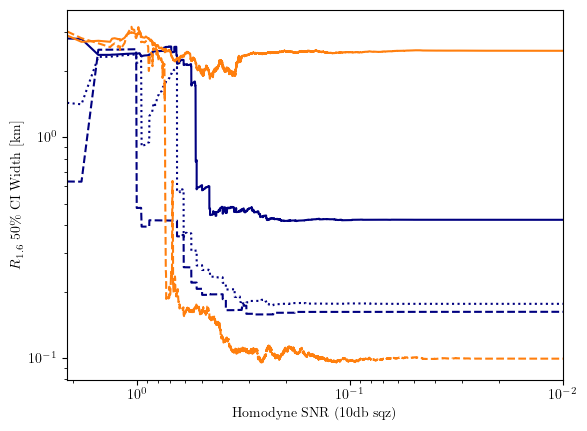

In [143]:
plt.plot(sorted_snrs_silica, np.array(pc_r1d6_widths), color="navy", label='Photon Counting 1cl PSD')
plt.plot(sorted_snrs_silica, np.array(pc_r1d6_widths_0d1), color="navy", ls=':', label='Photon Counting 0.1 cl. PSD')
plt.plot(sorted_snrs_silica, np.array(pc_r1d6_widths_no_background), color="navy", ls='--', label='Photon Counting No background')
plt.plot(sorted_snrs_silica, np.array(pc_r1d6_widths_strain), color="C1", label='Homodyne 10dB squeezing')
plt.plot(sorted_snrs_silica, np.array(pc_r1d6_widths_strain_15db), color="C1", ls='--', label='Homodyne 15dB squeezing')
plt.xscale('log')
plt.yscale('log')
plt.xlim(np.max(sorted_snrs_silica), 1e-2)

plt.ylabel(r'$R_{1.6}$ 50\% CI Width [km]')
plt.xlabel(r'Homodyne SNR (10db sqz)')

In [144]:
inv_snr_cdf = interp1d(np.linspace(0,Nevents-1,Nevents), (sorted_snrs_silica), kind='linear', fill_value=((np.max(sorted_snrs_silica)), (np.min(sorted_snrs_silica))), bounds_error=False)

snr_cdf = interp1d((sorted_snrs_silica), np.linspace(0,Nevents-1,Nevents), kind='linear', fill_value=(0,Nevents), bounds_error=False)

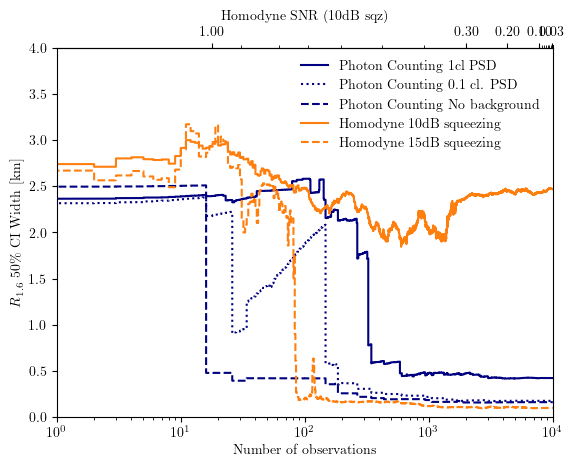

In [145]:
from matplotlib.ticker import LogLocator, LogFormatterMathtext

plt.step(np.linspace(0,Nevents-1,Nevents), np.array(pc_r1d6_widths), color="navy", label='Photon Counting 1cl PSD')
plt.step(np.linspace(0,Nevents-1,Nevents), np.array(pc_r1d6_widths_0d1), color="navy", ls=':', label='Photon Counting 0.1 cl. PSD')
plt.step(np.linspace(0,Nevents-1,Nevents), np.array(pc_r1d6_widths_no_background), color="navy", ls='--', label='Photon Counting No background')
plt.step(np.linspace(0,Nevents-1,Nevents), np.array(pc_r1d6_widths_strain), color="C1", label='Homodyne 10dB squeezing')
plt.step(np.linspace(0,Nevents-1,Nevents), np.array(pc_r1d6_widths_strain_15db), color="C1", ls='--', label='Homodyne 15dB squeezing')
plt.xlim(1,Nevents)

ax = plt.gca()
ax.set_ylim(0,4)
#ax.set_xlim(1,10000)
ax.set_xscale('log')
#ax.set_yscale('log')

secax = ax.secondary_xaxis('top', functions=(inv_snr_cdf, snr_cdf))
secax.set_xlabel('Homodyne SNR (10dB sqz)')
#secax.set_xscale('log')
#secax.invert_xaxis()
#secax.set_xscale('log')

# # plot like this if linear in N
secax.set_xticks([1, 0.3, 0.2, 0.1, 0.03])
secax.set_xticklabels([1.0, r'$3\times10^{-1}$', r'$2\times10^{-1}$', r'$10^{-1}$', r'$3\times 10^{-2}$'])
secax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))

# # plot like this if log in N
#secax.set_xticks([1, 0.3, 0.1])
#secax.set_xticklabels([1.0, 0.3, 0.1])


plt.ylabel(r'$R_{1.6}$ 50\% CI Width [km]')
plt.xlabel(r'Number of observations')
plt.legend(loc='upper right', frameon=False)

In [146]:
CI_array_val_pc = np.zeros((Nevents, 1000))
CI_array_val_pc_0d1 = np.zeros((Nevents, 1000))
CI_array_val_pc_no_background = np.zeros((Nevents, 1000))
CI_array_val_strain = np.zeros((Nevents, 1000))
CI_array_val_strain_15db = np.zeros((Nevents, 1000))
CI_array_val_strain_20db = np.zeros((Nevents, 1000))

prob_pc = np.exp(logl_pc - np.max(logl_pc,axis=1)[:,None])/np.sum(np.exp(logl_pc- np.max(logl_pc,axis=1)[:,None]),axis=1)[:,None]
prob_pc_0d1 = np.exp(logl_pc_0d1 - np.max(logl_pc_0d1,axis=1)[:,None])/np.sum(np.exp(logl_pc_0d1- np.max(logl_pc_0d1,axis=1)[:,None]),axis=1)[:,None]
prob_pc_no_background = np.exp(logl_pc_no_background - np.max(logl_pc_no_background,axis=1)[:,None])/np.sum(np.exp(logl_pc_no_background- np.max(logl_pc_no_background,axis=1)[:,None]),axis=1)[:,None]
prob_strain = np.exp(logl_strain - np.max(logl_strain,axis=1)[:,None])/np.sum(np.exp(logl_strain- np.max(logl_strain,axis=1)[:,None]),axis=1)[:,None]
prob_strain_15db = np.exp(logl_strain_15db - np.max(logl_strain_15db,axis=1)[:,None])/np.sum(np.exp(logl_strain_15db- np.max(logl_strain_15db,axis=1)[:,None]),axis=1)[:,None]
prob_strain_20db = np.exp(logl_strain_20db - np.max(logl_strain_20db,axis=1)[:,None])/np.sum(np.exp(logl_strain_20db- np.max(logl_strain_20db,axis=1)[:,None]),axis=1)[:,None]

for i in tqdm(range(Nevents)):
    prob_interp = prob_pc[i]
    prob_pc_sorted_indexes = np.argsort(prob_interp)[::-1]
    prob_pc_sorted = prob_interp[prob_pc_sorted_indexes]
    CI_array_val_pc[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.9]] = 0.5
    CI_array_val_pc[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.68]] = 1

    prob_interp = prob_pc_0d1[i]
    prob_pc_sorted_indexes = np.argsort(prob_interp)[::-1]
    prob_pc_sorted = prob_interp[prob_pc_sorted_indexes]
    CI_array_val_pc_0d1[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.9]] = 0.5
    CI_array_val_pc_0d1[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.68]] = 1

    prob_interp = prob_pc_no_background[i]
    prob_pc_sorted_indexes = np.argsort(prob_interp)[::-1]
    prob_pc_sorted = prob_interp[prob_pc_sorted_indexes]
    CI_array_val_pc_no_background[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.9]] = 0.5
    CI_array_val_pc_no_background[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.68]] = 1

    prob_interp = prob_strain[i]
    prob_pc_sorted_indexes = np.argsort(prob_interp)[::-1]
    prob_pc_sorted = prob_interp[prob_pc_sorted_indexes]
    CI_array_val_strain[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.9]] = 0.5
    CI_array_val_strain[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.68]] = 1

    prob_interp = prob_strain_15db[i]
    prob_pc_sorted_indexes = np.argsort(prob_interp)[::-1]
    prob_pc_sorted = prob_interp[prob_pc_sorted_indexes]
    CI_array_val_strain_15db[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.9]] = 0.5
    CI_array_val_strain_15db[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.68]] = 1

    prob_interp = prob_strain_20db[i]
    prob_pc_sorted_indexes = np.argsort(prob_interp)[::-1]
    prob_pc_sorted = prob_interp[prob_pc_sorted_indexes]
    CI_array_val_strain_20db[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.9]] = 0.5
    CI_array_val_strain_20db[i, prob_pc_sorted_indexes[np.cumsum(prob_pc_sorted/(np.sum(prob_pc_sorted))) < 0.68]] = 1

100%|██████████| 10000/10000 [00:03<00:00, 2960.62it/s]


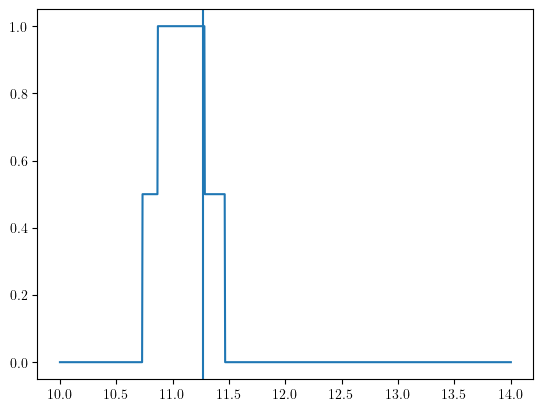

In [147]:
plt.plot(R1d6s_interp, CI_array_val_pc[-1])
plt.axvline(11.27)

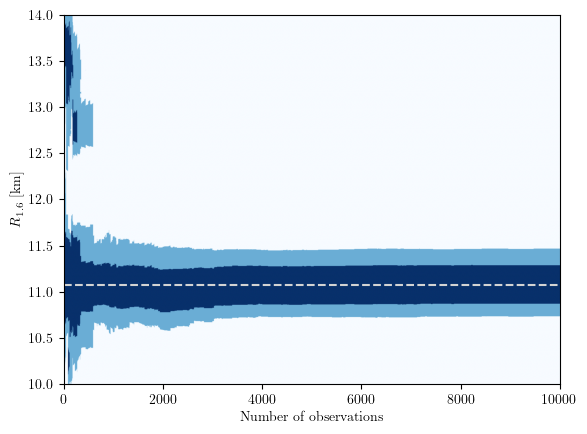

In [148]:
plt.imshow(CI_array_val_pc.T, aspect='auto', extent=(0, Nevents, 10, 14), origin='lower', cmap='Blues', vmin=0, vmax=1)
plt.xlabel('Number of observations')
plt.ylabel(r'$R_{1.6}$ [km]')
plt.axhline(11.07, color='lightgrey', label=r'APR4 $R_{1.6}$', linestyle='--')

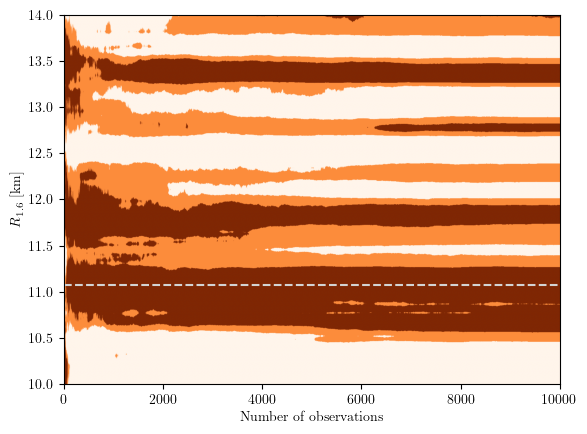

In [149]:
plt.imshow(CI_array_val_strain.T, aspect='auto', extent=(0, Nevents, 10, 14), origin='lower', cmap='Oranges', vmin=0, vmax=1)
plt.xlabel('Number of observations')
plt.ylabel(r'$R_{1.6}$ [km]')
plt.axhline(11.07, color='lightgrey', label=r'APR4 $R_{1.6}$', linestyle='--')

In [150]:
CI_array_val_pc[CI_array_val_pc < 1] = 0
CI_array_val_pc_sum = np.sum(CI_array_val_pc, axis=1) * (R1d6s_interp[1]-R1d6s_interp[0])
CI_array_val_pc_0d1[CI_array_val_pc_0d1 < 1] = 0
CI_array_val_pc_0d1_sum = np.sum(CI_array_val_pc_0d1, axis=1) * (R1d6s_interp[1]-R1d6s_interp[0])
CI_array_val_pc_no_background[CI_array_val_pc_no_background < 1] = 0
CI_array_val_pc_no_background_sum = np.sum(CI_array_val_pc_no_background, axis=1) * (R1d6s_interp[1]-R1d6s_interp[0])

CI_array_val_strain[CI_array_val_strain < 1] = 0
CI_array_val_strain_sum = np.sum(CI_array_val_strain, axis=1) * (R1d6s_interp[1]-R1d6s_interp[0])
CI_array_val_strain_15db[CI_array_val_strain_15db < 1] = 0
CI_array_val_strain_15db_sum = np.sum(CI_array_val_strain_15db, axis=1) * (R1d6s_interp[1]-R1d6s_interp[0])
CI_array_val_strain_20db[CI_array_val_strain_20db < 1] = 0
CI_array_val_strain_20db_sum = np.sum(CI_array_val_strain_20db, axis=1) * (R1d6s_interp[1]-R1d6s_interp[0])

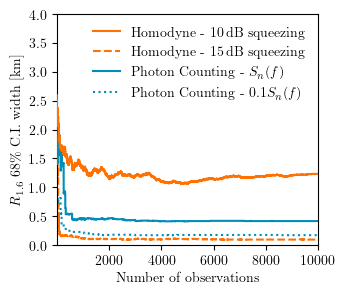

In [151]:
fig = plt.figure(figsize=(3.375,3))

plt.step(np.linspace(0,Nevents-1,Nevents, dtype=int), CI_array_val_strain_sum, color="#ff7100ff", label=r'Homodyne - 10\,dB squeezing', zorder=100)
plt.step(np.linspace(0,Nevents-1,Nevents, dtype=int), CI_array_val_strain_15db_sum, color="#ff7100ff", ls='--', label=r'Homodyne - 15\,dB squeezing')

plt.step(np.linspace(0,Nevents-1,Nevents, dtype=int), CI_array_val_pc_sum, color='#008eb8ff', label=r'Photon Counting - $S_n(f)$', zorder=99)
plt.step(np.linspace(0,Nevents-1,Nevents, dtype=int), CI_array_val_pc_0d1_sum, color='#008eb8ff', ls=':', label=r'Photon Counting - $0.1S_n(f)$')

plt.ylabel(r'$R_{1.6}$ 68\% C.I. width [km]')
plt.xlabel(r'Number of observations')
plt.xlim(1,Nevents)
plt.ylim(0,4)

#plt.xscale('log')

# for i in range(Nevents):
#     if signal_photons[sorted_indices_silica][i] > 0:
#         plt.axvline(x=i, color='#605B56',zorder=-10)

#plt.plot(np.linspace(0,Nevents-1,Nevents, dtype=int), CI_array_val_pc_no_background_sum[-1]*np.sqrt(np.sum(sorted_snrs_silica**2))/np.sqrt(np.cumsum(sorted_snrs_silica**2)), color='k', ls='--', label=r'$\propto 1/\sqrt{\sum\rho^2}$')
#plt.plot(np.linspace(0,Nevents-1,Nevents, dtype=int), CI_array_val_pc_sum[-1]*np.sqrt(np.sum(sorted_snrs_silica**2))/np.sqrt(np.cumsum(sorted_snrs_silica**2)), color='k', ls='--')

plt.legend(loc='upper right', frameon=False)
#plt.xscale('log')

plt.savefig("hierarchical_ci.pdf", bbox_inches='tight')

/tmp/ipykernel_4092193/1149938533.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,3)


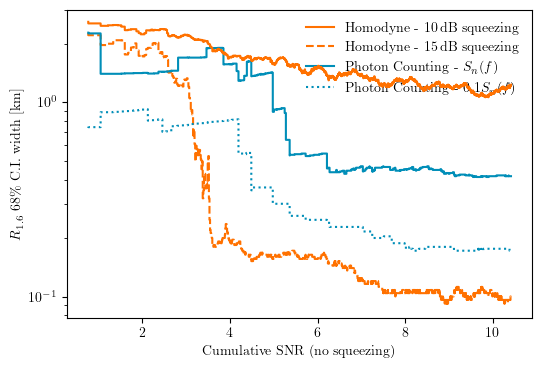

In [152]:
fig = plt.figure(figsize=(6,4))

plt.step(np.cumsum(sorted_snrs**2)**0.5, CI_array_val_strain_sum, color="#ff7100ff", label=r'Homodyne - 10\,dB squeezing', zorder=100)
plt.step(np.cumsum(sorted_snrs**2)**0.5, CI_array_val_strain_15db_sum, color="#ff7100ff", ls='--', label=r'Homodyne - 15\,dB squeezing')

plt.step(np.cumsum(sorted_snrs**2)**0.5, CI_array_val_pc_sum, color='#008eb8ff', label=r'Photon Counting - $S_n(f)$', zorder=99)
plt.step(np.cumsum(sorted_snrs**2)**0.5, CI_array_val_pc_0d1_sum, color='#008eb8ff', ls=':', label=r'Photon Counting - $0.1S_n(f)$')

plt.ylabel(r'$R_{1.6}$ 68\% C.I. width [km]')
plt.xlabel(r'Cumulative SNR (no squeezing)')
#plt.xscale('log')
plt.yscale('log')
#plt.xlim(1,Nevents)
plt.ylim(0,3)


# for i in range(Nevents):
#     if signal_photons[sorted_indices_silica][i] > 0:
#         plt.axvline(x=i, color='#605B56',zorder=-10)

#plt.plot(np.linspace(0,Nevents-1,Nevents, dtype=int), CI_array_val_pc_no_background_sum[-1]*np.sqrt(np.sum(sorted_snrs_silica**2))/np.sqrt(np.cumsum(sorted_snrs_silica**2)), color='k', ls='--', label=r'$\propto 1/\sqrt{\sum\rho^2}$')
#plt.plot(np.linspace(0,Nevents-1,Nevents, dtype=int), CI_array_val_pc_sum[-1]*np.sqrt(np.sum(sorted_snrs_silica**2))/np.sqrt(np.cumsum(sorted_snrs_silica**2)), color='k', ls='--')

plt.legend(loc='upper right', frameon=False)
#plt.yscale('log')

plt.savefig("hierarchical_snr_ci.pdf", bbox_inches='tight')

In [153]:
CI_array_val_pc_sum[-1]

np.float64(0.4164164164164532)

In [154]:
CI_array_val_strain_sum[-1]

np.float64(1.2332332332333422)

In [155]:
from astropy.cosmology import Planck18
from astropy import units as u

zmax = 10
zinterp = np.expm1(np.linspace(np.log1p(0), np.log1p(zmax), 2000))
dVdzdt_interp = 4*np.pi*Planck18.differential_comoving_volume(zinterp).to(u.Gpc**3/u.sr).value/(1+zinterp)

pdf_red = ((1+zinterp)**2.7)/(1+((1+zinterp)/2.9)**5.6) * dVdzdt_interp

In [156]:
integrated_pdf = np.sum(pdf_red) * (zinterp[1] - zinterp[0])

print(integrated_pdf)

1340.3179675286347


In [157]:
1e4/integrated_pdf/np.array([10,1700])

array([0.74609162, 0.00438877])

In [158]:
1e4/integrated_pdf/np.array([0.8,440])

array([9.32614522, 0.01695663])

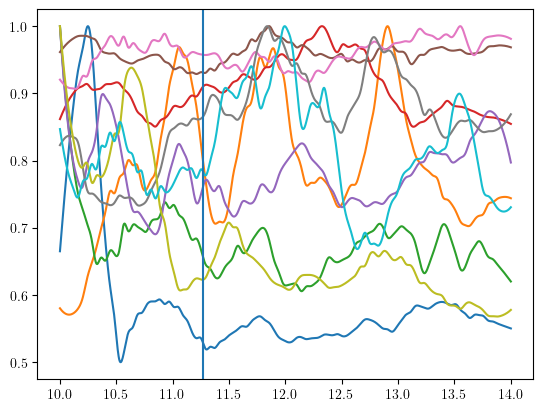

In [159]:
plt.plot(R1d6s_interp, np.exp(loglikelihoods_strain[sorted_indices_silica][:10].T - np.max(loglikelihoods_strain[sorted_indices_silica][:10], axis=1)), label='Homodyne 10dB')
plt.axvline(11.27)
#plt.ylim(-0.2,0)
#plt.ylim(0,)

In [160]:
file_list[sorted_indices_silica[0]]

'results_260217/result_CE_0.json'

In [161]:
attempt1 = np.sum((loglikelihoods[sorted_indices_silica][0:1000]-np.max(loglikelihoods[sorted_indices_silica][0:1000])),axis=0)

In [162]:

# for idx in range(60,80):
#     plt.plot(R1d6s_interp, np.exp(loglikelihoods_strain[sorted_indices_silica][idx]-np.max(loglikelihoods_strain[sorted_indices_silica][idx])))
# plt.ylim(0)

(0.0, 1.0497543417063993)

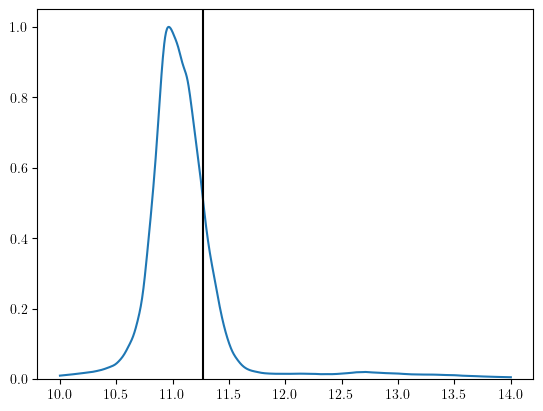

In [163]:
plt.plot(R1d6s_interp, np.exp(attempt1 - np.max(attempt1)))
plt.axvline(11.27, color='k')
plt.ylim(0,)

In [164]:
sorted_indices_silica[:10]

array([   0,    1,    2,    3, 9931,    4,    7,    8,    6,    5])

In [165]:
snrs_silica[234]

np.float64(0.5638205532176915)

In [166]:
file_list[:Nevents][sorted_indices_silica[234]]

'results_260217/result_CE_232.json'

In [167]:
sorted_snrs_silica

array([2.14073641, 1.83215907, 1.52721775, ..., 0.00485698, 0.00381781,
       0.00320268], shape=(10000,))

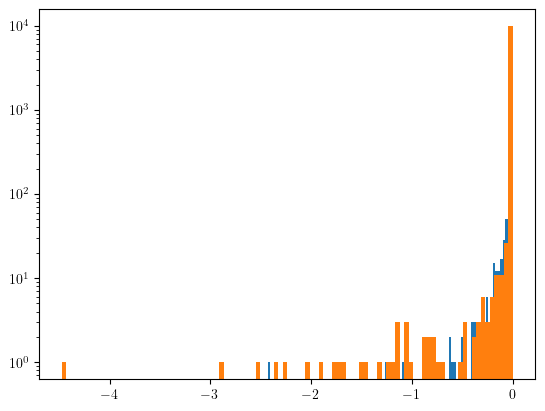

In [168]:
plt.hist(np.min(loglikelihoods.T-np.max(loglikelihoods,axis=1),axis=0), bins=100)
plt.hist(np.min(loglikelihoods_0d1.T-np.max(loglikelihoods_0d1,axis=1),axis=0), bins=100)
plt.yscale('log')
plt.show()

In [169]:
np.argmin(np.min(loglikelihoods_strain.T-np.max(loglikelihoods_strain,axis=1),axis=0))

np.int64(0)

In [170]:
log10As = np.random.uniform(-6, 1, size=100)
As = 10**log10As
weights = As *np.log(10)

In [171]:
eff = np.sum(weights)**2/np.sum(weights**2)/100

print(eff)

0.14694992318179995


(array([ 5.98680991, 13.42026631,  8.265841  , 12.28509778,  6.72032129,
         0.        , 41.12940712, 12.11619014, 27.53696819, 16.31250963]),
 array([1.06421345e-06, 7.08444249e-01, 1.41688743e+00, 2.12533062e+00,
        2.83377381e+00, 3.54221699e+00, 4.25066018e+00, 4.95910336e+00,
        5.66754655e+00, 6.37598973e+00, 7.08443292e+00]),
 <BarContainer object of 10 artists>)

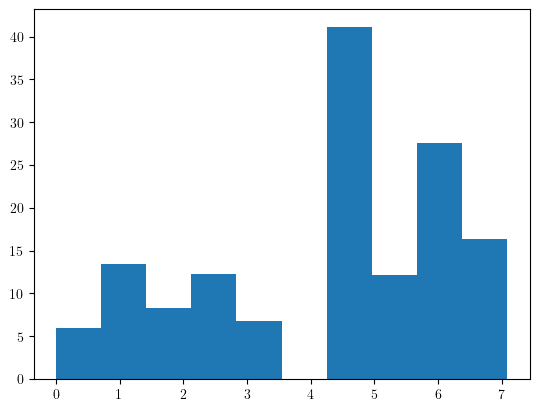

In [172]:
plt.hist(As, weights=weights)

In [173]:
with open('results_250620/result_CE_10995.json', "r") as f:
        result = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'results_250620/result_CE_10995.json'

In [ ]:
plt.plot(R1d6s, np.exp(result["logls_strain"]-np.max(result["logls_strain"])), label='Photon Counting')

In [ ]:
result

In [ ]:

frequencies = np.sort(np.fft.fftfreq(2**13, d=1/1e4))

white_noise_time = np.random.randn(int(len(frequencies)))

white_noise_freq = interp1d(np.fft.fftfreq(len(frequencies), d=1/1e4), np.fft.fft(white_noise_time))(frequencies)

In [ ]:
np.fft.fftfreq(len(frequencies), d=1/1e4).shape, np.fft.fft(white_noise_time).shape

In [ ]:
def generate_colored_noise(psd_data, frequencies):

    N = len(frequencies)
    T = 1/(frequencies[1] - frequencies[0])  # Assuming uniform frequency spacing
    amplitude = np.sqrt(0.5*T * psd_data) # NOTE THAT THE PSD IS ONE SIDED

    noise_real = np.random.normal(0, 1, N)
    noise_imag = np.random.normal(0, 1, N)
    noise_freq = amplitude * (noise_real + 1j * noise_imag)

    noise_freq[0] = noise_freq[0].real + 0j
    noise_freq[N//2] = noise_freq[N//2].real + 0j
    noise_freq[N//2+1:] = np.conj(noise_freq[1:N//2][::-1])

    return noise_freq#np.concatenate([noise_freq[N//2+1:], noise_freq[1:N//2]])

In [ ]:
noise = generate_colored_noise(np.ones(len(frequencies)), frequencies)

In [ ]:
plt.plot(frequencies, noise)

In [ ]:
frequencies = np.sort(np.fft.fftfreq(2**13, d=1/1e4))

detector_sqz = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE_total_psd_sqz.csv', None, 
    gamma=100, random_seed=1632, N_frequency_spaces=10, N_time_spaces=10)

gaussian_likelihood = GWPhotonCounting.distributions.GaussianStrainLikelihood()

In [ ]:
noise_realization = gaussian_likelihood.generate_realization(detector_sqz.total_psd, frequencies)

In [ ]:
plt.semilogy(frequencies, np.abs(noise_realization))
#plt.semilogy(frequencies, detector_sqz.total_psd**0.5)


In [ ]:
plt.loglog(frequencies, np.abs(noise_realization), label='Realization')
plt.loglog(frequencies, np.abs(detector_sqz.total_psd)**0.5, label='PSD')

plt.xlim(1000,4000)
plt.ylim(1e-27,1e-23)

In [ ]:
np.sum(frequencies >= 0)

In [ ]:
frequencies

In [ ]:
frequencies = np.fft.fftfreq(2**13, d=1/10**4)

In [ ]:
2**13/10**4

In [ ]:
1/np.diff(frequencies)[0]